# Simple Monte Carlo Glauber model
We will create the geometry of a heavy-ion collision. First, we have to sample the positions of nucleons inside the nucleus. We do so by using a Woods-Saxon distribution for radial coordinate, $r$, 

$$\rho(r;R,A) = \frac{1}{1 + e^{\frac{r-R}{a}}}\quad,$$

where $R$ is the average radius of the nucleus and $a$ the so-called difuseness.  
We use uniform distributions of the polar and azimuth angles $\theta$ and $\phi$, respectively. Note that the volume element in speherical coordinates is given by $dV = r^2 \sin\theta dr d\theta d\phi$. 

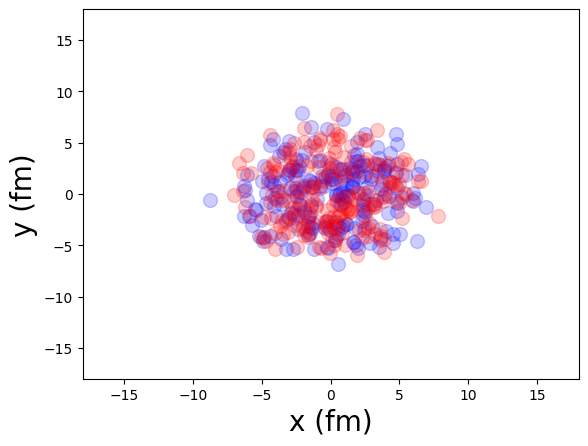

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz,cumtrapz
from matplotlib.lines import Line2D
from numpy import average, cov
# This is a very basic notebook so we define the nuclear parameters as global variables
# We are going to generate two Pb nuclei
R_Pb = 6.68  #[fm^-1]
a_Pb = 0.546 #[fm^-1]
N_Pb = 208
sigma_inel = 70 #[mb]
b = 0 # [fm]
np.random.seed(42) # Set the random number generator to a fixed sequence

# Woods Saxon distribution
def WoodsSaxon(r,R,a):
    # note that we include the r^2 coming from the volume element
    return r*r / (1 + np.exp((r-R)/a)) 

# Takes any PDF 'prob' and returns N numbers distributed according to it
def sample_r(x,prob,N):
    CDF = cumtrapz(prob)/np.sum(prob) # calculate the cumulative distribution
    xsamples = np.zeros(N,float)
    for i in range(0,N):
        r = np.random.ranf()
        xsamples[i] = x[CDF.searchsorted(r)]
    return xsamples

# Sample the polar angle
def sample_theta(N):
    # Note that we include the sin(th) coming from the volume element
    ctheta = 2 * np.random.random_sample(N) - 1 # cos(th)
    stheta = np.sqrt(1 - ctheta ** 2) # sin(th)
    return ctheta, stheta

# Sample the azimuthal angle
def sample_phi(N):    
    phi  = 2 * np.pi * np.random.random_sample(N) # phi = [0,2 pi]
    cphi = np.cos(phi) 
    sphi = np.sin(phi) 
    return cphi, sphi 

# Simple function to convert from spherical to cartesian coordinates
def sample_xyz(rtest,N):
    r = sample_r(rtest,WoodsSaxon(rtest,R_Pb,a_Pb),N)
    ctheta, stheta = sample_theta(N)
    cphi, sphi = sample_phi(N)
    x = r * cphi * stheta
    y = r * sphi * stheta
    z = r * ctheta
    return np.array([x,y,z]).T

# Set centre-of-mass of the nucleus to be at 0
def recenter_nucleons(xyz):
    mxyz = xyz.mean(axis=0)
    return xyz - mxyz

# Do some plotting
rtest = np.arange(0.,18.,0.1)

nucleusA = recenter_nucleons(sample_xyz(rtest,N_Pb))
nucleusB = recenter_nucleons(sample_xyz(rtest,N_Pb))

plt.xlim(-18.,18.)
plt.ylim(-18.,18.)
plt.xlabel("x (fm)",fontsize=20)
plt.ylabel("y (fm)",fontsize=20)
plt.plot(nucleusA[:,0],nucleusA[:,1],"bo",markersize=10,alpha=0.2)
plt.plot(nucleusB[:,0],nucleusB[:,1],"ro",markersize=10,alpha=0.2)
plt.show()


Once the nucleons are distributed in each nucleus we want to compute how many of them collide. To that end, we introduce a simple geometric model in which two nucleons are said to interact if they are close enough, i.e. $d<\sqrt{\sigma/\pi}$, with $\sigma$ the inelastic cross-section. 

In [295]:
# Function that returns the nucleons that have collided and the total number of collisions
def Ncoll(nucA, nucB, sigma):
    mbtofm2 = 0.1 # converter from mb to fm2
    sigma_fm = sigma*mbtofm2 
    d = np.sqrt(sigma_fm/np.pi)
    # obtain the number of nucleons
    N = np.size(nucA[:,0])
    collA = [] # [x,y,z] coordinates of the nucleons that have collided
    collB = []
    ncollA = np.zeros(N) # number of times each nucleon has interacted
    ncollB = np.zeros(N)
    for i in range(0,N):
        for j in range(0,N):
            # check whether they satisfy the geometric criterion
            if np.sqrt((nucA[i,0]-nucB[j,0])**2+(nucA[i,1]-nucB[j,1])**2+(nucA[i,2]-nucB[j,2])**2) <= d:
                ncollA[i]+=1 # We keep track of how many times a nucleon interact
                ncollB[j]+=1
                if nucA[i,:] not in collA: collA = np.append(collA,nucA[i,:]).reshape(-1,3) # avoid same nucleon appearing multiple times
                if nucB[j,:] not in collB: collB = np.append(collB,nucB[j,:]).reshape(-1,3)
    return collA, collB, ncollA, ncollB

Another ingredient in the geometry of a heavy-ion collision is the distance at which the two nuclei pass, the so-called impact parameter. 

In [296]:
# Allow for a non-zero impact parameter
def shift_by_b(aa,bb,b):
    bv    =  b/2*np.array([1,0,0])
    return aa + bv, bb - bv 

At this point it's useful to introduce a function that does all the steps for us: disposes the nucleons in transverse space, ensures the correct center of mass, shifts the nucleons by a given impact parameter and calculates the number of collisions and participants.

In [297]:
# Function that does all the steps
def collide(rsample,N,imp,sigma):
    nucleusA = recenter_nucleons(sample_xyz(rsample,N))
    nucleusB = recenter_nucleons(sample_xyz(rsample,N))
    aa,bb    = shift_by_b(nucleusA,nucleusB,imp)
    ac,bc,nac,nbc = Ncoll(aa,bb,sigma)
    return aa, bb, ac, bc, nac, nbc

Finally, we are going to calculate some hallmark quantities in heavy-ion collisions such as the eccentricity and the triangularity 
of the collision. To that end, we need to calculate the weighted average of the positions of the participants
\begin{equation}
  \overline{x} = \frac{\sum_{i=1}^{N_{\mathrm{part}}} w_i x_i}{\sum_{i=1}^{N_{\mathrm{part}}}w_i}
\end{equation}


In [298]:
def mean_position(xyz,colls):
    m = average(xyz,weights=colls,axis=0)
    return m

The eccentricity moments are then given by 
\begin{equation}
\varepsilon_n = \frac{\sqrt{\overline{r^n\cos n\phi}^2 + \overline{r^n\sin n\phi}^2}}{\overline{r^n}}
\end{equation}
We will focus on $\varepsilon_2$ and $\varepsilon_3$. 

In [299]:
def eccentricities(parts,mean,maxn=3): 
    shift = parts - mean 
    phis  = np.arctan2(shift[:,1],shift[:,0])
    rs    = np.sqrt(shift[:,0]**2+shift[:,1]**2)
    ecc   = np.zeros(maxn)
    for n in range(2,maxn+1):
        w         = n
        rn        = rs**w
        rncosnphi = (rn*np.cos(n*phis)).mean()
        rnsinnphi = (rn*np.sin(n*phis)).mean()
        ecc[n-2]  = np.sqrt(rncosnphi**2+rnsinnphi**2)/rn.mean()
    eps2 = ecc[0]
    eps3 = ecc[1]
    return eps2, eps3

In [300]:
# do some interactive plotting
from ipywidgets import interactive
def Glauber(b):
    ax = plt.gca()
    plt.xlim(-18.,18.)
    plt.ylim(-18.,18.)
    plt.xlabel("x (fm)",fontsize=20)
    plt.ylabel("y (fm)",fontsize=20)
    # Set up the nuclei 
    nucleusA,nucleusB,nucleusA_coll,nucleusB_coll,ncollA,ncollB = collide(rtest,N_Pb,b,sigma_inel)
    ncoll  = sum(ncollA+ncollB)
    nparta = len(nucleusA_coll)
    npartb = len(nucleusB_coll)
    # Calculate the eccentricity and triangularity
    means = mean_position(np.concatenate((nucleusA_coll,nucleusB_coll)),np.concatenate((ncollA[ncollA!=0],ncollB[ncollB!=0])))    
    eps2,eps3 = eccentricities(np.concatenate((nucleusA_coll,nucleusB_coll)),means)

    plt.title(fr'$b={b}$ fm, ' 
            fr'$N_{{\rm{{coll}}}}={ncoll}$, '
            fr'$N_{{\rm{{part}}}}={nparta}+{npartb}={nparta+npartb}$, '
            fr'$\varepsilon_2 = {eps2:10.2f}$, '
            fr'$\varepsilon_3 = {eps3:10.2f}$')
    # Plot nuclei
    nucA = plt.Circle((b/2,0), R_Pb ,fill = False, color='crimson', linestyle='--')
    ax.add_artist(nucA)
    nucB = plt.Circle((-b/2,0), R_Pb ,fill = False, color='navy', linestyle='--')
    ax.add_artist(nucB)
    # All nucleons
    plt.plot(nucleusA[:,0],nucleusA[:,1],c="crimson",marker='o',linestyle='None',markersize=10,markerfacecolor='none')
    plt.plot(nucleusB[:,0],nucleusB[:,1],c='navy',marker='o',linestyle='None',markersize=10, markerfacecolor='none')
    # Participating nucleons
    plt.plot(nucleusA_coll[:,0],nucleusA_coll[:,1],c="crimson",marker='o',linestyle='None',markersize=10, alpha=0.2)
    plt.plot(nucleusB_coll[:,0],nucleusB_coll[:,1],c='navy',marker='o',linestyle='None',markersize=10, alpha=0.2)
    
    # Things for the legend
    aproxy = Line2D([],[],color='crimson',label='A')
    bproxy = Line2D([],[],color='navy',label='B')
    sproxy = Line2D([],[],color='k',marker='o',
                    linestyle='none',
                    markersize=10,
                    markerfacecolor='none',
                    label='Spectator')
    pproxy = Line2D([],[],color='k',marker='o',
                    linestyle='none',
                    markersize=10,
                    markerfacecolor=(0,0,0,.1),
                    markeredgecolor='k',
                    label='Participant')
    ax.legend(handles=[aproxy,sproxy,bproxy,pproxy],ncol=2)
    plt.show()

interactive_plot = interactive(Glauber, b=(0,10,0.5))
interactive_plot

interactive(children=(FloatSlider(value=5.0, description='b', max=10.0, step=0.5), Output()), _dom_classes=('w…